# Import Modules

In [1]:
import pandas as pd
import re
import nltk
nltk.download('wordnet')
nltk.download('punkt')


from langdetect import detect
import matplotlib.pyplot as plt

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tomev\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tomev\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Fetch Dataset

In [2]:
#current directory containing dataset
directory = "Dataset/"

#read training set
train_csv = pd.read_csv(directory+"mediaeval-2015-trainingset.txt", sep="\t", quoting=3)
train_df = pd.DataFrame(data = train_csv)

#read test set
test_csv = pd.read_csv(directory+"mediaeval-2015-testset.txt", sep="\t", quoting=3)
test_df = pd.DataFrame(data = test_csv)


#train_df = pandas.read_table("Dataset/mediaeval-2015-trainingset.txt", sep="\t",lineterminator='\n', skiprows=(0),  header=(0))
#test_df = pandas.read_table("Dataset/mediaeval-2015-testset.txt", sep="\t", lineterminator='\n', skiprows=(0),  header=(0))


# Data Characterisation and Visualisation

In [ ]:
#Dataset information, mainly different fields and size
train_df.info()
print()
test_df.info()

In [ ]:
#shape of training/test sets
print(train_df.shape)
print(test_df.shape)

In [ ]:
#example of dataset entities
train_df.head()

In [3]:
#renaming ImageId(s) as clunky column name
train_df.rename(columns={'imageId(s)': 'imageId'}, inplace=True)

test_df.rename(columns={'imageId(s)': 'imageId'}, inplace=True)


In [ ]:
#events categorised by ImageID (train)
print("Train:")
selected_events = train_df["imageId"].str.split('_').str[0].value_counts()
print(selected_events) 
selected_events.plot(kind="barh")
plt.title("Training Set Events")
plt.show()



In [ ]:
#events categorised by ImageID (test)
print("Test:")
selected_events = test_df["imageId"].str.split('_').str[0].value_counts()
print(selected_events) 
selected_events.plot(kind="barh")
plt.title("Test Set Events")
plt.show()

In [ ]:
#example tweets for different events

event = "sandy" #change variable for different events

total_df = train_df + test_df
selected_tweets = total_df[total_df["imageId"].str.contains(event, na=False)]["tweetText"].head(30)
print(selected_tweets)

In [ ]:
#number of languages in training set
trainLangs = {}

for text in train_df["tweetText"]:
    try:
        lan = detect(text)
    except:
        pass
        lan = "Unknown"
    trainLangs[lan] = trainLangs.get(lan, 0) + 1
  
print(trainLangs)

# top 4 languages 
top_langs = dict(sorted(trainLangs.items(), key=lambda x: x[1], reverse=True)[:4])

# sum of values for the top 4 languages
top_langs_sum = sum(top_langs.values())

# other langauges with the sum of values for the remaining categories
other_langs = {'Other': sum(trainLangs.values()) - top_langs_sum}

combined_data = {**top_langs, **other_langs}

# Plot a pie chart 
plt.pie(combined_data.values(), labels=combined_data.keys(), autopct='%1.1f%%', startangle=90)
plt.title("Training Set Languages")
plt.show()



In [ ]:
#number of languages in test set
testLangs = {}

for text in test_df["tweetText"]:
    try:
        lan = detect(text)
    except:
        pass
        lan = "Unknown"
    testLangs[lan] = testLangs.get(lan, 0) + 1
  

print(testLangs)

# top 4 languages 
top_langs = dict(sorted(testLangs.items(), key=lambda x: x[1], reverse=True)[:4])

# sum of values for the top 4 languages
top_langs_sum = sum(top_langs.values())

# other langauges with the sum of values for the remaining categories
other_langs = {'Other': sum(testLangs.values()) - top_langs_sum}

combined_data = {**top_langs, **other_langs}

# Plot a pie chart 
plt.pie(combined_data.values(), labels=combined_data.keys(), autopct='%1.1f%%', startangle=90)
plt.title("Test Set Languages")
plt.show()



In [ ]:
#Searching for duplicate tweets in training
print(train_df["tweetText"].describe())
print(f"duplicates:  {train_df['tweetText'].duplicated().sum()}")



In [ ]:
#Searching for duplicate tweets in test
print(test_df["tweetText"].describe())
print(f"duplicates:  {test_df['tweetText'].duplicated().sum()}")

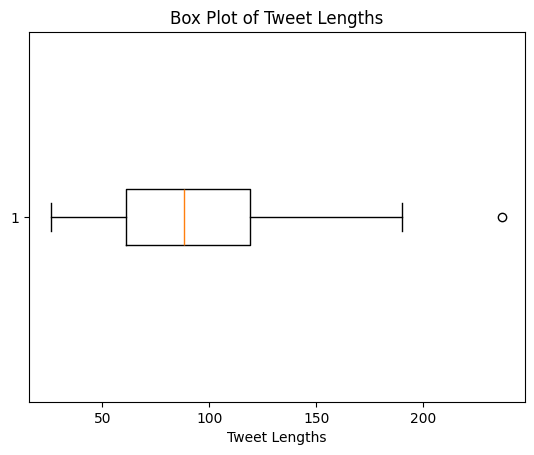

Highest Reasonable Value: 190.0


In [4]:
#compare lengths of tweets in training
train_df["tweetLength"] = train_df["tweetText"].apply(len)

bp = plt.boxplot(train_df["tweetLength"], vert=False)

#use right whisker of box plot to get highest reasonable value
max_legit_value = bp["whiskers"][1].get_data()[0][1]

plt.title("Box Plot of Tweet Lengths")
plt.xlabel("Tweet Lengths")
plt.show()

print(f"Highest Reasonable Value: {max_legit_value}")

In [ ]:
#investigate 1 outliers
#top_indices = train_df["tweetLength"].nlargest(1).index
#longest_tweets = train_df.loc[top_indices, "tweetText"]

longest_tweet = train_df['tweetText'].loc[train_df['tweetText'].str.len().idxmax()]

print(longest_tweet)
print(f"Length: {len(longest_tweet)}")

#tweet looks valid






In [ ]:
# NOT USED after changing how dataset is read in
#used to debug longest tweet cause

#n = 15
#print(f"Tweet:\n{longest_tweets.values[n]}\nLength: {len(longest_tweets.values[n])}")

#Above process confirms that the 15th longest tweet 
#(according to the box plot) is actually the correct longest tweet

# Data Preprocessing

- remove broken length tweets - done
- remove duplicates 
- Change humor to fake - done
- Remove URLs
- Remove certain punctiation
- Remove whitespace and stopwords 
- Tokenise


- Remove re-tweets and reposts
- Remove usernames
- Remove emojis
- Don't remove #
- Don't remove URLS





In [ ]:
#NOT NEEDED
#removing 15 outliers containing multiple tweets (tweets longer than 237)
train_df = train_df[train_df["tweetLength"] < 238]

#new distribution of tweet lengths
plt.hist(train_df["tweetLength"], bins=100, edgecolor='black')

plt.title("Tweet Lengths")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

#top 10 new longest tweets
top_indices = train_df["tweetLength"].nlargest(10).index
longest_tweets = train_df.loc[top_indices, "tweetText"]
print(longest_tweets)

#longest tweet
print(f"\n{longest_tweets.values[0]}\nLength: {len(longest_tweets.values[0])}")


In [5]:
#replace 'humor' label with 'fake'
#train_df['label'] = train_df['label'].replace('humor', 'fake')
#test_df['label'] = test_df['label'].replace('humor', 'fake')

#replace 'humor' label with 'fake' and map to 1 and 0 for ease of use when training and evaluating. Fake: 1, real: 0
train_df['label'] = train_df['label'].map({'fake': 1, 'humor': 1, 'real': 0})
test_df['label'] = test_df['label'].map({'fake': 1, 'humor': 1, 'real': 0})


In [6]:
#Clean tweet text by removing unnecessary noise
#experiment with for best performance (some processes achieve similiar things)

train_df["cleanText"] = train_df["tweetText"]
test_df["cleanText"] = test_df["tweetText"]

def cleanText(text):
    
    #remove URLs
    text = re.sub(r'http\S+|\\\/\S+', ' ', text)

    #remove usernames 
    text = re.sub(r'@\w*', " ", text)

    #remove punctuation
    text = re.sub(r'[^a-zA-Z ]+', ' ', text)

    text = text.lower()
    
    return text

#apply cleantext
train_df['cleanText'] = train_df['cleanText'].apply(cleanText)
test_df['cleanText'] = test_df['cleanText'].apply(cleanText)


#remove extra white space
train_df['cleanText'] = train_df['cleanText'].str.replace(r'\s+', ' ', regex=True)
test_df['cleanText'] = test_df['cleanText'].str.replace(r'\s+', ' ', regex=True)


#remove stopwords
sw = nltk.corpus.stopwords.words()
train_df['cleanText'] = train_df['cleanText'].apply(lambda x: ' '.join([w for w in x.split() if w not in sw]))
test_df['cleanText'] = test_df['cleanText'].apply(lambda x: ' '.join([w for w in x.split() if w not in sw]))


In [7]:
#lemmatise to reduce total word count
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WhitespaceTokenizer

lemmatiser = WordNetLemmatizer()
tokeniser = WhitespaceTokenizer()

train_df['cleanText'] = train_df['cleanText'].apply(lambda x: ' '.join([lemmatiser.lemmatize(w) for w in tokeniser.tokenize(x)]))



In [8]:
#remove duplicates
print(train_df["cleanText"].duplicated().sum())
train_df.drop_duplicates(subset=["cleanText"], keep="first", inplace=True)
print(train_df["cleanText"].duplicated().sum())


3951
0


Longest Tweet:
rt bringbackourgirls bringbackourgirls bringbackourgirls bringbackourgirls bringbackourgirls bringbackourgirls
Length: 110


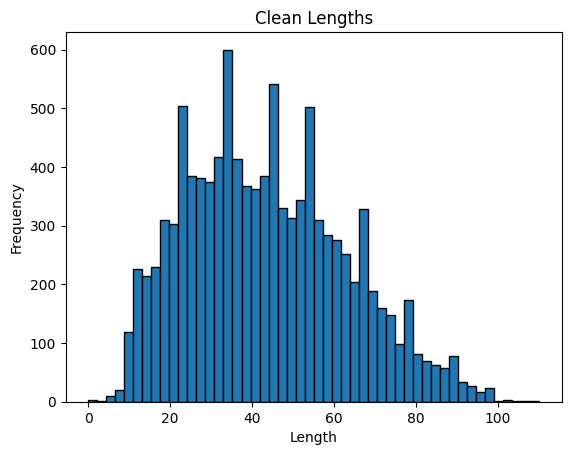

In [9]:
#lengths of cleaned text 
train_df["cleanLength"] = train_df["cleanText"].apply(len)

top_indices = train_df["cleanLength"].nlargest(16).index
longest_tweets = train_df.loc[top_indices, "cleanText"]

print(f"Longest Tweet:\n{longest_tweets.values[0]}\nLength: {len(longest_tweets.values[0])}")

#new distribution of cleaned lengths
plt.hist(train_df["cleanLength"], bins=50, edgecolor='black')

plt.title("Clean Lengths")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()


In [10]:
#tokenise
from nltk.tokenize import word_tokenize

# Assuming df_train is your DataFrame and 'cleanText' is the column you want to tokenize
train_df["tokenisedText"] = train_df["cleanText"].apply(lambda x: word_tokenize(x))

test_df["tokenisedText"] = test_df["cleanText"].apply(lambda x: word_tokenize(x))



In [11]:
train_df.head(5)

,tweetId,tweetText,userId,imageId,username,timestamp,label,tweetLength,cleanText,cleanLength,tokenisedText
0,263046056240115712,¿Se acuerdan de la película: “El día después d...,21226711,sandyA_fake_46,iAnnieM,Mon Oct 29 22:34:01 +0000 2012,1,134,acuerdan cula despu ana recuerda pasando hurac...,52,"[acuerdan, cula, despu, ana, recuerda, pasando..."
1,262995061304852481,@milenagimon: Miren a Sandy en NY! Tremenda i...,192378571,sandyA_fake_09,CarlosVerareal,Mon Oct 29 19:11:23 +0000 2012,1,133,miren sandy ny tremenda imagen hurac parece in...,65,"[miren, sandy, ny, tremenda, imagen, hurac, pa..."
2,262979898002534400,"Buena la foto del Huracán Sandy, me recuerda a...",132303095,sandyA_fake_09,LucasPalape,Mon Oct 29 18:11:08 +0000 2012,1,116,buena foto hurac sandy recuerda cula independe...,59,"[buena, foto, hurac, sandy, recuerda, cula, in..."
3,262996108400271360,Scary shit #hurricane #NY http://t.co/e4JLBUfH,241995902,sandyA_fake_29,Haaaaarryyy,Mon Oct 29 19:15:33 +0000 2012,1,46,scary shit hurricane ny,23,"[scary, shit, hurricane, ny]"
4,263018881839411200,My fave place in the world #nyc #hurricane #sa...,250315890,sandyA_fake_15,princess__natt,Mon Oct 29 20:46:02 +0000 2012,1,89,fave place world nyc hurricane sandy statueofl...,52,"[fave, place, world, nyc, hurricane, sandy, st..."


In [12]:
test_df.head(5)

,tweetId,tweetText,userId,imageId,username,timestamp,label,cleanText,tokenisedText
0,578854927457349632,kereeen RT @Shyman33: Eclipse from ISS.... htt...,70824972,eclipse_01,peay_s,Fri Mar 20 09:45:43 +0000 2015,1,kereeen rt eclipse,"[kereeen, rt, eclipse]"
1,578874632670953472,Absolutely beautiful! RT @Shyman33: Eclipse fr...,344707006,eclipse_01,JaredUcanChange,Fri Mar 20 11:04:02 +0000 2015,1,absolutely beautiful rt eclipse,"[absolutely, beautiful, rt, eclipse]"
2,578891261353984000,“@Shyman33: Eclipse from ISS.... http://t.co/C...,224839607,eclipse_01,tpjp1231,Fri Mar 20 12:10:06 +0000 2015,1,eclipse wow amazing,"[eclipse, wow, amazing]"
3,578846612312748032,Eclipse from ISS.... http://t.co/En87OtvsU6,134543073,eclipse_01,Shyman33,Fri Mar 20 09:12:41 +0000 2015,1,eclipse,[eclipse]
4,578975333841551360,"""@ebonfigli: Éclipse vue de l'ISS... Autre cho...",1150728872,eclipse_01,Epimethee_,Fri Mar 20 17:44:11 +0000 2015,1,clipse vue autre chose cr ation divine limite,"[clipse, vue, autre, chose, cr, ation, divine,..."


# Pipeline Design

In [13]:
#import relevant sklearn modules
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier


#used to perform tf-idf feature selection in the pipelines
vectorizer = TfidfVectorizer()

#used to perform svd dimension reduction in the pipelines
svd = TruncatedSVD(n_components=100)



In [14]:
#pipeline 1 using Multinomial Naive Bayes
pipeline_1 = mnb_pipeline = Pipeline([
    ('vect', vectorizer),
    ('svd', svd),
    ('mnb', MultinomialNB())
])


In [15]:
#pipeline 1 using Multilayer Perceptron
pipeline_1 = mnb_pipeline = Pipeline([
    ('vect', vectorizer),
    ('svd', svd),
    ('mlp', MLPClassifier(hidden_layer_sizes=(100,), max_iter=500))
])

In [16]:
#pipeline_2 using Stochastic Gradient Descent
pipeline_2 = Pipeline([
    ('vect', vectorizer),
    ('svd', svd),
    ('sgd', SGDClassifier())
])

# Model Training and Testing

In [17]:
#splitting training set into train and val
#x = features, y = labels
X_train, X_val, y_train, y_val = train_test_split(train_df["cleanText"], train_df["label"], test_size=0.2, random_state=69)

In [50]:
#training pipeline_1 
pipeline_1.fit(X_train, y_train)

#evaluating pipeline_1
accuracy_1 = pipeline_1.score(X_val, y_val)
print("accuracy:   %0.3f" % accuracy_1)


accuracy:   0.864


C:\Users\tomev\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [51]:
#training pipeline_2 
pipeline_2.fit(X_train, y_train)

#evaluating pipeline_1
accuracy_2 = pipeline_2.score(X_val, y_val)
print("accuracy:   %0.3f" % accuracy_2)


accuracy:   0.840


In [20]:
#predicting on test set
pred_test_1 = pipeline_1.predict(test_df["cleanText"])

pred_test_2 = pipeline_2.predict(test_df["cleanText"])

# Evaluation

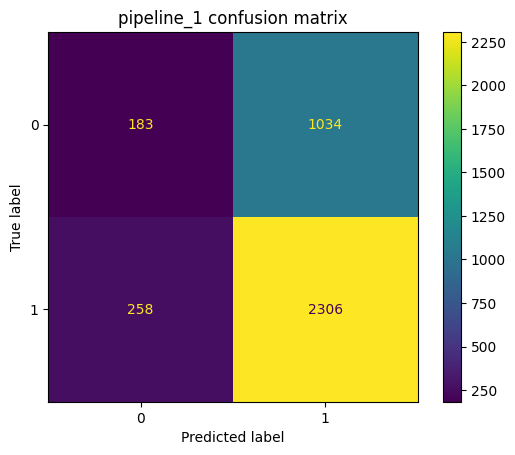

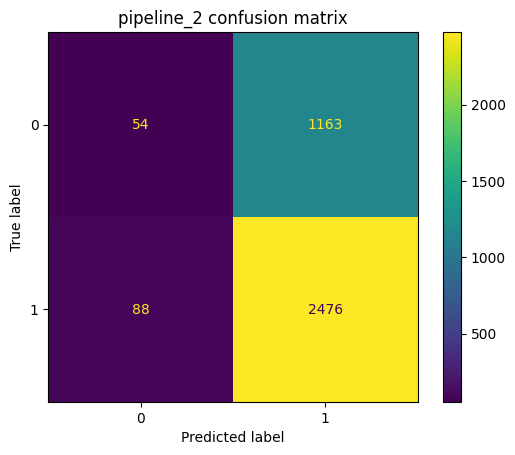

pipeline_1 classification report:

              precision    recall  f1-score   support

           0       0.41      0.15      0.22      1217
           1       0.69      0.90      0.78      2564

    accuracy                           0.66      3781
   macro avg       0.55      0.52      0.50      3781
weighted avg       0.60      0.66      0.60      3781


pipeline_2 classification report:

              precision    recall  f1-score   support

           0       0.38      0.04      0.08      1217
           1       0.68      0.97      0.80      2564

    accuracy                           0.67      3781
   macro avg       0.53      0.51      0.44      3781
weighted avg       0.58      0.67      0.57      3781



In [49]:
#evaluating pipeline performance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report


cm_1 = confusion_matrix(test_df['label'], pred_test_1)
disp_1 = ConfusionMatrixDisplay(confusion_matrix=cm_1, display_labels=pipeline_1.classes_).plot()

plt.title("pipeline_1 confusion matrix")
plt.show()

#confusion matrix for pipeline_2

cm_2 = confusion_matrix(test_df['label'], pred_test_2)
disp_1 = ConfusionMatrixDisplay(confusion_matrix=cm_2, display_labels=pipeline_2.classes_).plot()

plt.title("pipeline_2 confusion matrix")
plt.show()


#Classification Report 1

report_1 = classification_report(test_df['label'], pred_test_1)
print("pipeline_1 classification report:\n")
print(report_1)



#Classification Report 2
report_2 = classification_report(test_df['label'], pred_test_2)
print("\npipeline_2 classification report:\n")
print(report_2)


